# Rotary plot

Loads depth-frequency-time rotary data and then plots for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2
for i in range(2):
    %matplotlib notebook

In [8]:
# import data

adcp = 'Axis75'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [9]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values
f = ds[0].specf.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]
gm_cw = gm[:,2]
gm_ccw = gm[:,3]

In [10]:
# select and average time

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_cw,phi_ccw = [],[],[]
for i in range(n_seg):
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_list.append(ds[i].spect[j].values)
            phi_cw.append(ds[i].cw[:,:,j])                 # time segment, [depth, freq]
            phi_ccw.append(ds[i].ccw[:,:,j])
avg_cw = sum(phi_cw)/len(dt_list)
avg_ccw = sum(phi_ccw)/len(dt_list)

print("Output time range:",dt_list[0],'to',dt_list[-1])     # print to check desired interval

Output time range: 2013-01-06T08:07:30.000000000 to 2013-12-21T16:07:30.000000000


## Depth-average rotary (annual)

In [11]:
# WKB scale and depth average

WKB_cw = avg_cw / ds[0].WKB_scale
WKB_ccw = avg_ccw / ds[0].WKB_scale

if adcp == 'Slope':
    didx = -24           # -9 for lower depth (-315), -24 for mid-depth (-195)
elif adcp == 'Axis75':
    didx = -22           # -7 for lower depth (-920), -22 for mid-depth (-800)
elif adcp == 'Axis55':
    didx = -4           # -4 for lower depth (-913), -10 for mid-depth (-793)

cw = WKB_cw[didx,:].values
ccw = WKB_ccw[didx,:].values
d_stamp = ds[0].depth[didx].values

# depth_cw = WKB_cw.mean(dim='depth')
# depth_ccw = WKB_ccw.mean(dim='depth')

print('Depth:',-d_stamp,'m')

Depth: -800 m


In [12]:
# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)             # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

cw_lower = cw * cint[0]             # define upper and lower confidence values
cw_upper = cw * cint[1]
ccw_lower = ccw * cint[0]             # define upper and lower confidence values
ccw_upper = ccw * cint[1]

<IPython.core.display.Javascript object>


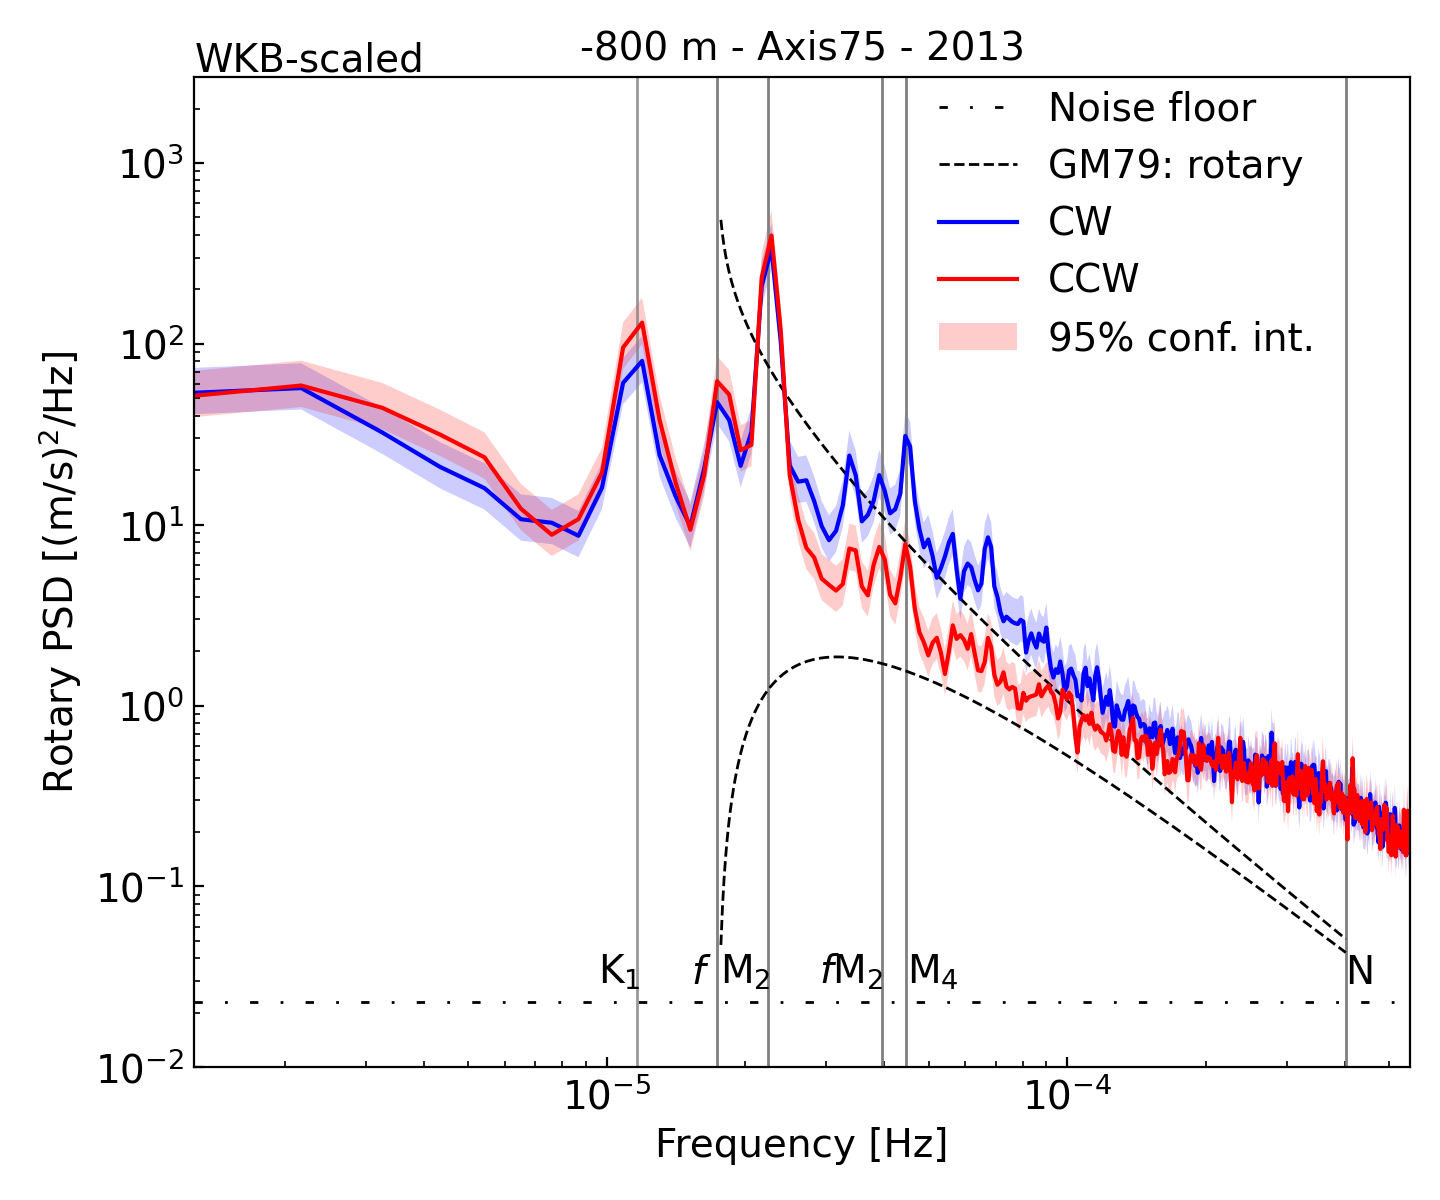

In [13]:
# plot rotary

fig, ax = plt.subplots(1,1,figsize=(7.2,6))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
fig.text(0.415,0.18,'K$_1$',fontsize=14)
fig.text(0.48,0.18,'$f$',fontsize=14)
fig.text(0.50,0.18,'M$_2$',fontsize=14)
fig.text(0.569,0.18,'$f$M$_2$',fontsize=14)
fig.text(0.63,0.18,'M$_4$',fontsize=14)
fig.text(0.934,0.18,'N',fontsize=14)
fig.text(0.135,0.94,'WKB-scaled',fontsize=14)

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_title(f'-{d_stamp} m - {adcp} - {t_stamp}',fontsize=14)
ax.set_ylabel('Rotary PSD [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')

ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='black',lw=1,ls='--') # rotary GM
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='black',lw=1,ls='--', label='GM79: rotary') # rotary GM

ax.loglog(f, cw, label='CW',color='blue')
ax.loglog(f, ccw, label='CCW',color='red')

ax.fill_between(f, cw_lower, cw_upper, facecolor='blue', alpha=0.2)
ax.fill_between(f, ccw_lower, ccw_upper, facecolor='red', alpha=0.2, label='95% conf. int.')

fig.tight_layout()
plt.legend(loc=[0.6,0.7],frameon=False,fontsize=14)
plt.show()

plt.savefig(fname=f'./plots/rot_plots/rot_{adcp}_{d_stamp}_{t_stamp}.pdf',format='pdf')

## Multi-annual depth-average

In [ ]:
# save annual data to .nc file

ds_out = xr.Dataset( 
    data_vars=dict(
        cw=(['f'], cw),    # PSD data
        ccw=(['f'], ccw),
    ),
    coords=dict(
        f=f,              
    ),
    attrs=dict(
        description=f'Rotary data from {adcp} for {t_stamp}.',
        d_stamp = d_stamp,
    ),
) 
ds_out.to_netcdf(f'../Data/multiannual/rot_{adcp}_{t_stamp}.nc')

In [ ]:
# plot multi-annual data

multi_adcp = 'Slope'       # Slope or Axis
if multi_adcp == 'Slope':
    ds0 = xr.open_dataset(f'../Data/multiannual/rot_Slope_2013.nc')
    ds1 = xr.open_dataset(f'../Data/multiannual/rot_Slope_2014.nc')
    ds2 = xr.open_dataset(f'../Data/multiannual/rot_Slope_2017.nc')
    ds3 = xr.open_dataset(f'../Data/multiannual/rot_Slope_2018.nc')
elif multi_adcp == 'Axis':
    ds0 = xr.open_dataset(f'../Data/multiannual/rot_Axis75_2013.nc')
    ds1 = xr.open_dataset(f'../Data/multiannual/rot_Axis75_2014.nc')
    ds2 = xr.open_dataset(f'../Data/multiannual/rot_Axis55_2017.nc')
    ds3 = xr.open_dataset(f'../Data/multiannual/rot_Axis55_2018.nc')
    
multi_cw = (ds0.cw + ds1.cw + ds2.cw + ds3.cw) / 4
multi_ccw = (ds0.ccw + ds1.ccw + ds2.ccw + ds3.ccw) / 4

# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)                # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

multi_cw_lower = multi_cw * cint[0]             # define upper and lower confidence values
multi_cw_upper = multi_cw * cint[1]          
multi_ccw_lower = multi_ccw * cint[0]             # define upper and lower confidence values
multi_ccw_upper = multi_ccw * cint[1]

# plot rotary

fig, ax = plt.subplots(1,1,figsize=(7.2,6))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
fig.text(0.415,0.18,'K$_1$',fontsize=14)
fig.text(0.48,0.18,'$f$',fontsize=14)
fig.text(0.50,0.18,'M$_2$',fontsize=14)
fig.text(0.569,0.18,'$f$M$_2$',fontsize=14)
fig.text(0.63,0.18,'M$_4$',fontsize=14)
fig.text(0.934,0.18,'N',fontsize=14)
fig.text(0.135,0.94,'WKB-scaled',fontsize=14)

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_title(f'-{ds3.d_stamp} m - {multi_adcp} - Time-mean',fontsize=14)
ax.set_ylabel('Rotary PSD [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if multi_adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif multi_adcp == 'Axis':
    ax.axhline(0.19,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')   # averaged uncertainty for noise floor
    
ax.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='black',lw=1,ls='--') # rotary GM
ax.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='black',lw=1,ls='--', label='GM79: rotary') # rotary GM

ax.loglog(f, multi_cw, label='CW',color='blue')
ax.loglog(f, multi_ccw, label='CCW',color='red')

ax.fill_between(f, multi_cw_lower, multi_cw_upper, facecolor='blue', alpha=0.2)
ax.fill_between(f, multi_ccw_lower, multi_ccw_upper, facecolor='red', alpha=0.2,label='95% conf. int.')

fig.tight_layout()
plt.legend(loc=[0.6,0.7],frameon=False,fontsize=14)
plt.show()

plt.savefig(fname=f'./plots/rot_plots/rot_{multi_adcp}_{ds3.d_stamp}_multi.pdf',format='pdf')